In [7]:
import torch
import math
import time
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue      
size=1000;
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    dlc_practical_prologue.generate_pair_sets(size)
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable((train_classes))
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)
mini_batch_size = 100


In [2]:
#    Train_classes_One_Hot_IM1=dlc_practical_prologue.convert_to_one_hot_labels(train_input.narrow(1,0,1), train_classes.narrow(1,0,1))
#    Train_classes_One_Hot_IM2=dlc_practical_prologue.convert_to_one_hot_labels(train_input.narrow(1,1,1), train_classes.narrow(1,1,1))


The goal of this project is to implement a deep network such that, given as input a series of 2×14×14 tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is lesser or equal to the second.

The training and test set should be 1, 000 pairs each, and the size of the images allows to run experiments rapidly, even in the VM with a single core and no GPU.

You can generate the data sets to use with the function generate_pair_sets(N) defined in the file dlc_practical_prologue.py.

|      Name     | Tensor Dimension |   Type  |                  Content                 |
|:-------------:|:----------------:|:-------:|:----------------------------------------:|
|  Train_input  |  N x 2 x 14 x 14 | float32 |                  Images                  |
|  Train_target |         N        |  int64  |          Class to predict €{0,1}         |
| Train_classes |       N x 2      |  int64  | Classes of the two digits € {0, ... ,9 } |
|   Test_input  |  N x 2 x 14 x 14 | float32 |                  Images                  |
|  Test_target  |         N        |  int64  |          Class to predict €{0,1}         |
|  Test_classes |       N x 2      |  int64  | Classes of the two digits € {0, ... ,9 } |

The goal of the project is to compare different architectures, and assess the performance improvement that can be achieved through weight sharing, or using auxiliary losses.

For the latter, the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest.

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000 parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each architecture, where both data and weight initialization are randomized, and you should provide estimates of standard deviations.


Model sharing weights + boolean comparison at the end :

In [24]:
class Full_Model(nn.Module):
    def __init__(self, nb_hidden):
        super(Full_Model, self).__init__()
        """Modele 1 for digit recognition"""
        self.Layer1 = nn.Linear(196, nb_hidden)
        self.Layer2 = nn.Linear(nb_hidden, 10)
        """Modele 2 for digit comparison"""
        self.Digit = nn.Linear(20, 2)
    def forward(self,input_):
        img1=input_.narrow(1, 0,1);
        img2=input_.narrow(1, 1,1);
        x = F.relu(self.Layer1(img1.view(-1, 196)))
        x = self.Layer2(x)
        y = F.relu(self.Layer1(img2.view(-1, 196)))
        y = self.Layer2(y)
        xy=torch.cat((x,y),1)
        z= self.Digit(xy)
        #z=xy
        Classe_X = (torch.argmax(x,1))
        Classe_Y = (torch.argmax(y,1))
        z2=Classe_X<=Classe_Y
        return   x,y,z,z2
def train_model(model, train_input, train_classes,train_target):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.001)
    nb_epochs = 25
    sum_array=[]
    for e in range(nb_epochs):  
        sum_loss=0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss0 = criterion(output[0], train_classes.narrow(0, b, mini_batch_size).narrow(1,0,1).view(-1))#Loss for Img1
            loss1 = criterion(output[1], train_classes.narrow(0, b, mini_batch_size).narrow(1,1,1).view(-1))#Loss for Img2
            loss2 = criterion(output[2], train_target.narrow(0, b, mini_batch_size))#Loss for total model
            loss_T=0.5*loss0 + 0.5*loss1 +1*loss2  
            model.zero_grad()
            loss_T.backward()
            optimizer.step()
            sum_loss= sum_loss + loss_T.item()
        sum_array.append(sum_loss)
    return e, sum_array 
def compute_nb_errors(model, data_input, data_classe,data_target):
    nb_data_errors_im1 = 0
    nb_data_errors_im2 = 0
    nb_data_errors_Final = 0
    nb_data_errors_Final2 = 0
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes_images0 = torch.max(output[0].data, 1)#Display error for Img0
        _, predicted_classes_images1 = torch.max(output[1].data, 1)#Display error for Img1
        _, predicted_classes_output = torch.max(output[2].data, 1)#Display error for ouput
        predicted_classes_output2 = output[3]
        for k in range(mini_batch_size):
            if data_classe.data[b + k][0] != predicted_classes_images0[k]:
                nb_data_errors_im1 = nb_data_errors_im1 + 1
            if data_classe.data[b + k][1] != predicted_classes_images1[k]:
                nb_data_errors_im2 = nb_data_errors_im2 + 1
            if data_target.data[b + k] != predicted_classes_output[k]:
                nb_data_errors_Final = nb_data_errors_Final + 1
            if data_target.data[b + k] != predicted_classes_output2[k].long():
                nb_data_errors_Final2 = nb_data_errors_Final2 + 1
    return nb_data_errors_im1, nb_data_errors_im2, nb_data_errors_Final, nb_data_errors_Final2

In [25]:
#return   x,y, z
#         0  1  2  3    4   5  6

for std in [ -1 ]:
   
    model=Full_Model(200);
    print('std {:f} '.format(std))
    print(compute_nb_errors(model,train_input,train_classes,train_target))
    print(compute_nb_errors(model,test_input,test_classes,test_target))
    if std > 0:
        for p in model.parameters(): p.data.normal_(0, std)
    time1 = time.perf_counter()
    e, sum_array= train_model(model, train_input, train_classes,train_target)
    time2 = time.perf_counter()
    print(compute_nb_errors(model,train_input,train_classes,train_target))
    print(compute_nb_errors(model,test_input,test_classes,test_target))
    print('Throughput {:e} s'.format((time2 - time1)))

std -1.000000 
(893, 890, 515, 466)
(870, 878, 513, 418)
(24, 26, 32, 17)
(150, 146, 206, 95)
Throughput 1.140663e+00 s


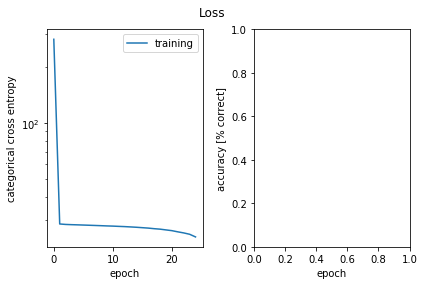

In [69]:
import matplotlib.pyplot as plt

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history, label = "training")
    finalize_standardplot(fig, ax1, ax2)
    return fig

plot_history(sum_array,"Loss");

In [16]:
output = model(train_input.narrow(0, 0, 10))
output[2].size()
z=output[2]
z[1].float()


tensor(0.)

In [39]:
print(model.parameters())

<generator object Module.parameters at 0x000002B15F21CC78>


In [47]:
for k in model.parameters():
    print(k.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([200, 64])
torch.Size([200])
torch.Size([10, 200])
torch.Size([10])
torch.Size([2, 20])
torch.Size([2])


In [61]:
img1=train_input.narrow(0,0,1).narrow(1,0,1)
conv1 = nn.Conv2d(1, 32, kernel_size=3)
conv2 = nn.Conv2d(32, 64, kernel_size=3)
print(img1.size())
x=F.relu(F.max_pool2d(conv1(img1), kernel_size=3, stride=2))
print(x.size())
x=F.relu(F.max_pool2d(conv2(x), kernel_size=3, stride=1))
print(x.size())

torch.Size([1, 1, 14, 14])
torch.Size([1, 32, 5, 5])
torch.Size([1, 64, 1, 1])


In [21]:
output = model(train_input.narrow(0, 0, 10))
output[3][0]

tensor(0, dtype=torch.uint8)